In [1]:
# Import all the packages needed to perform the sample size validation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

import math

import hyperopt
from hyperopt import fmin, tpe, hp,space_eval

from hpsklearn import all_regressors

from sklearn.pipeline import Pipeline
import itertools

from sklearn.kernel_approximation import Nystroem
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import GroupKFold
from sklearn.compose import TransformedTargetRegressor

from hyperopt.early_stop import no_progress_loss
from sklearn.model_selection import cross_val_score

from joblib import delayed, Parallel

import h5py

import warnings
from sklearn.exceptions import ConvergenceWarning

import os
import pickle

In [2]:
# Now, some auxiliary functions are presented.

# The function buil_dict(mdl_base) builds a dictionary of pre-established spaces for the Bayesian optimization of the hyperparamters of model "mdl_base".
def buil_dict(mdl_base):
    lst = mdl_base.named_args
    dictn={}
    for ll in lst:
        dictn[ll[0]]=ll[1]
    return dictn

# The function removekeys(d,keys) manipulates a dictionary "d" and remove keys in the list "keys" from it.
def removekeys(d, keys):
    r = dict(d)
    for keyv in keys:
        del r[keyv]
    return r

# The function e_from_Psi(psiv,lambdav,gamma,p0) calculates the value of the void ratio corresponding to the psi value considered.
def e_from_Psi(psiv,lambdav,gamma,p0):
    return psiv + (gamma - lambdav * np.log(p0))

In [3]:
# The functions below allow one to read the values from the NorSand4AI datasets.
# The functions starting with "inner_" all perform the reading of an individual .h5 file and retrieve the information of interest.
# The function "inner_drain" and "inner_undrain" get the values of ["ep1","e","p","q"] for the drained and undrained simulations.
# On the other hand, function "inner_par" gets the values of the parameters used for the simulations.
# The function "read_final_comp(path_root,n_samples,n_samples_2,dictpos)" looks for all the simulations in "path_root" for the 
#  "n_samples" number of material types and "n_samples_2" number of test conditions. Then, it reorganizes the order of the parameters for
#  each test to match the order of the keys in "dictpos". The output is an array with all the input parameters for the simulations considered.
# The function "read_organize_Simus_H5_Ultralight(final_comp,n_samples_2,path_root)" looks for all the simulations in "path_root" for the 
#  "n_samples_2" number of test conditions. It also takes the array with all the input parameters for the simulations considered and then outputs
#  all the simulation results separated by material types.

def inner_drain(pvi,path_root,n_samples_2):
    matv = int(math.floor(pvi/n_samples_2))
    with h5py.File(path_root+"\\Simus\\Drained\\Par_"+str(matv)+"_"+str(pvi)+".h5", 'r') as f:
        df_int = pd.DataFrame(np.array(f['NorSandTXL']),columns = ["ep1","epV","p","q","e","pi/p","(pi/p)max","Psi","Dp","eta"])
    return df_int[["ep1","e","p","q"]]

def inner_undrain(pvi,path_root,n_samples_2):
    matv = int(math.floor(pvi/n_samples_2))
    with h5py.File(path_root+"\\Simus\\Undrained\\Par_"+str(matv)+"_"+str(pvi)+".h5", 'r') as f:
        df_int = pd.DataFrame(np.array(f['NorSandTXL']),columns = ["ep1","epV","p","q","e","pi/p","(pi/p)max","Psi","Dp","eta"])
    return df_int[["ep1","e","p","q"]]

def inner_par(pvi,path_root,n_samples_2):
    matv = int(math.floor(pvi/n_samples_2))
    with h5py.File(path_root+"\\Simus\\Undrained\\Par_"+str(matv)+"_"+str(pvi)+".h5", 'r') as f:
        df_int = [[y,f['NorSandTXL'].attrs[y]] for y in [x for x in f['NorSandTXL'].attrs]]
    return df_int

def read_final_comp(path_root,n_samples,n_samples_2,dictpos):
    dft = Parallel(n_jobs=32)(delayed(inner_par)(*x) for x in [[i,path_root,n_samples_2] for i in range(n_samples*n_samples_2)])
    final_vals=[]
    for w in dft:
        positions_keys = [np.argwhere(np.array(w).T[0]==z).flatten()[0] for z in dictpos.keys()]
        final_vals.append(np.array(w).T[1][positions_keys].astype(np.float32))
    return np.array(final_vals)

def read_organize_Simus_H5_Ultralight(final_comp,n_samples_2,path_root):
    U_chnk=[]
    D_chnk=[]
    inptsss = [[pvi,path_root,n_samples_2] for pvi in range(len(final_comp))]
    D_chnk = Parallel(n_jobs=32)(delayed(inner_drain)(*x) for x in inptsss)
    U_chnk = Parallel(n_jobs=32)(delayed(inner_undrain)(*x) for x in inptsss)
    chunks_D = [D_chnk[x:x+n_samples_2] for x in range(0, len(D_chnk),n_samples_2)]
    chunks_U = [U_chnk[x:x+n_samples_2] for x in range(0, len(U_chnk),n_samples_2)]
    chunks_par = [final_comp[x:x+n_samples_2] for x in range(0, len(final_comp),n_samples_2)]
    return [chunks_D,chunks_U,chunks_par]

In [7]:
# This is a usage example:
n_samples = 2048
n_samples_2 = 42
n_parallel_jobs = 32
path_root = "D:\\NorSand_2048_42\\"

dictpos = {"Gamma":[6,4],"lambda":[7,4],"Mtc":[14,4],"N":[15,4],
           "Xtc": [16,4],"H0":[17,4],"Hy":[18,4], "Gmax_p0":[21,4],
           "G_exp": [22,4], "nu":[23,4],"Psi_0":[27,4],"p0":[29,4],
           "K0": [30,4], "OCR": [32,4]}

In [8]:
final_comp = read_final_comp(path_root,n_samples,n_samples_2,dictpos)

In [9]:
H5Nchunks_D,H5Nchunks_U,H5Nchunks_par = read_organize_Simus_H5_Ultralight(final_comp,n_samples_2,path_root)

In [4]:
# Now that both the input parameters and the simulations results have been retrieved, to maintain consistency, since the final values of ep1
#  for each simulation is different, we need to trimm all the results up to the minimum of maximum values of ep1 for each simulation.
#  Thus, we find ep1max.

ep1maxu = np.floor(100*np.min([np.max(z["ep1"]) for x in H5Nchunks_U for z in x]))/100
ep1minu = np.max([np.min(z["ep1"]) for x in H5Nchunks_U for z in x])
ep1maxd = np.floor(100*np.min([np.max(z["ep1"]) for x in H5Nchunks_D for z in x]))/100
ep1mind = np.max([np.min(z["ep1"]) for x in H5Nchunks_D for z in x])
ep1max = np.min([ep1maxd,ep1maxu])

In [6]:
# Now, we need to downsample our 4000x3 arrays (ep1 will be the index) as most of these values do not bring much information. We chose to lineraly subsample
#  each simulation using logarithmic scale, such that more points are sampled at low values of ep1, which is where the most significant
#  changes normally happen.
# This way, function "build_new_e(exp_U,exp_D,ep1max,npts)" performs this trimming and sub-sampling procedure, using "ep1max" as the trimming value
#  and "npts" as the number of points to perform the loglinear subsampling on both "exp_U" and "exp_D", which are the 4000x3 arrays of simulation results
#  for the undrained and draned cases, respectively.
# We also need to sub-sample our n_samples materials and n_samples_2 test conditions to show how changing these values impact the learning task
#  we aim to carry out. Thus, error_evol_inpts(H5Nchunks_U,H5Nchunks_D,H5Nchunks_par,nmat,ntest) performs such subsampling by selecting the first 
#  "nmat" material types and "ntest" test conditions. This is only possible on the datasets generated using extensible (Sobol and Halton) quasi-Monte Carlo sampling.

def downsample_df_e(df_inp,idexinterp):
    finlst=[]
    for df_inpi in df_inp:
        df_single = df_inpi.copy()
        df_single = df_single[["ep1","e","p","q"]]
        df_single = df_single[df_single["ep1"]<=20]
        df_single = df_single.set_index("ep1")
        df_single = df_single[~df_single.index.duplicated(keep='first')]
        df1 = df_single.reindex(df_single.index.union(idexinterp))
        df1 = df1.interpolate('index')
        finlst.append(df1.loc[idexinterp])
    return finlst

def build_new_e(exp_U,exp_D,ep1max,npts):
    idexinterp = np.round(np.logspace(-3,np.log10(ep1max),npts),4)
    inptsssU = [(x,idexinterp) for x in exp_U]
    inptsssD = [(x,idexinterp) for x in exp_D]
    exp_U_ds = Parallel(n_jobs=32)(delayed(downsample_df_e)(*x) for x in inptsssU)
    exp_D_ds = Parallel(n_jobs=32)(delayed(downsample_df_e)(*x) for x in inptsssD)
    return [exp_U_ds,exp_D_ds]

def error_evol_inpts(H5Nchunks_U,H5Nchunks_D,H5Nchunks_par,nmat,ntest):
    par_mat_U = [x[:int(ntest)] for x in H5Nchunks_U[:int(nmat)]]
    par_mat_D = [x[:int(ntest)] for x in H5Nchunks_D[:int(nmat)]]
    par_inp_mat = [x[:int(ntest)] for x in H5Nchunks_par[:int(nmat)]]
    return par_mat_D,par_mat_U,par_inp_mat

In [8]:
# We then define the values of "nmat" and "ntest" we will be using. Due to the Sobol sampling implementation considered,
#  the samples (and sub-samples) must have size 2**m, where m is a natural number. We chose a 7x7 grid of values, as defined below.
# Also, we considered a loglinear sub-sampling of 40 points.

slices_mat = [2**n for n in range(5,12)]
slices_test = [6*n for n in range(1,8)]
npts =40

In [13]:
# The nested loop below performs the trimming and sub-sampling procedures described and saves the corresponding file to disk. These files
#  will be later imported for the learning task calibration.

for sz1 in slices_mat:
    for sz2 in slices_test:
        a,b,c = error_evol_inpts(H5Nchunks_U,H5Nchunks_D,H5Nchunks_par,sz1,sz2)
        tr_dfs = build_new_e(b,a,ep1max,npts)
        tr_dfs_par = np.array(c).reshape(sz1*sz2,c[0].shape[1])
        for tpt,vvv in zip(["Undrained","Drained"],tr_dfs):
            train_nparray = np.array([x.to_numpy() for x in [z for w in vvv for z in w ]])
            np.save(path_root+"txltsts_"+str(tpt)+"_"+str(sz1)+"_"+str(sz2)+".npy", train_nparray)
            np.save(path_root+"features_"+str(tpt)+"_"+str(sz1)+"_"+str(sz2)+".npy", tr_dfs_par)

In [9]:
# As described in the paper, the Latin Hypercube Sampling dataset with 2000 soil types and 40 test conditions will be used as the test
#  dataset. Thus, even though we do not need to sub-sample it with respect to the number of materials and test conditions, we do need
#  to sub-sample it with respect to ep1. Thus, we will use the same trimming value of ep1max and number of points npts to sub-sample 
#  the 4000x3 (one shall remember that ep1 will be the index) to 40x3.

n_samples_test = 2000
n_samples_2_test = 40
n_parallel_jobs = 32
path_root_test = "D:\\NorSand_2000_40\\"

In [15]:
final_comp_test = read_final_comp(path_root_test,n_samples_test,n_samples_2_test,dictpos)

In [16]:
H5Nchunks_D_test,H5Nchunks_U_test,H5Nchunks_par_test = read_organize_Simus_H5_Ultralight(final_comp_test,n_samples_2_test,path_root_test)

In [17]:
# We will also save the trimmed/downsampled version of the 2000x40 LHS dataset to disk.

tr_dfs = build_new_e(H5Nchunks_U_test,H5Nchunks_D_test,ep1max,npts)
tr_dfs_par = final_comp_test
for tpt,vvv in zip(["Undrained","Drained"],tr_dfs):
    train_nparray = np.array([x.to_numpy() for x in [z for w in vvv for z in w ]])
    np.save(path_root_test+"txltsts_"+str(tpt)+".npy", train_nparray)
    np.save(path_root_test+"features_"+str(tpt)+".npy", tr_dfs_par)

In [11]:
# We now define the function which will carry out the learning task we chose (predict input simulation parameters from the triaxial
#  tes results). This is performed by the function BayesianSearch, whose argumets are:
#   a) random_state: an integer which sets the random seed of the code to ensure reproducibility of the search algorithm;
#   b) inner_folds: number of folds for the GroupKFold cross validation used during hyperparameter tuning;
#   c) candidate_mdl: candidate model to be trained
#   d) n_samples: number of material types considered (2048), used to find the corresponding folder with results.
#   e) n_samples_2: number of test conditions considered (42), used to find the corresponding folder with results.
#   f) typev: type of triaxial test considered (Drained or Undrained);
#   g) ori_path: path where the train/validation datasets are;
#   h) test_path: path where the test datasets are;
# The function BayesianSearch does not consider nonlinear kernels for the inputs nor trasformed output values.
# The function BayesianSearch outputs a simple string "ok". It also saves the learning results to disk, for usage and manipulation latter.
# The function BayesianSearch saves two lists to disk, which contain:
#  a) [mdl_name,"HoldOut-",real_vals_diff,bst_mdl.get_params(),np.mean(real_vals_diff,axis=0)], where:
#   a.1) mdl_name: model name;
#   a.2) "HoldOut-": label string;
#   a.3) real_vals_diff: absolute percentage error for each test sample;
#   a.4) bst_mdl.get_params(): the best hyperparemeters found after Bayesian optimization;
#   a.5) np.mean(real_vals_diff,axis=0): mean absolute percentage error for each input parameter considering the whole test sample;
#  b) [mdl_name,"HoldOut-",np.array([yhat,outputstest]),bst_mdl.get_params()] 
#   b.1) mdl_name: model name;
#   b.2) "HoldOut-": label string;
#   b.3) np.array([yhat,outputstest]): array with both the predicted value and the real test value for each test sample;
#   b.4) bst_mdl.get_params(): the best hyperparemeters found after Bayesian optimization;

def BayesianSearch(random_state,inner_folds,candidate_mdl,n_samples,n_samples_2,typev,ori_path,test_path):
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    warnings.filterwarnings("ignore", category=UserWarning)
    sz1,sz2 = n_samples,n_samples_2
    features = np.load(ori_path+"txltsts_"+str(typev)+"_"+str(sz1)+"_"+str(sz2)+".npy")
    outputs = np.load(ori_path+"features_"+str(typev)+"_"+str(sz1)+"_"+str(sz2)+".npy")
    featurestest = np.load(test_path+"txltsts_"+str(typev)+".npy")
    outputstest = np.load(test_path+"features_"+str(typev)+".npy")
    for linev in outputs:
        for i in range(1):
            linev[10+4*i] = e_from_Psi(linev[10+4*i],linev[1],linev[0],linev[11+4*i])
    for linev2 in outputstest:
        for i in range(1):
            linev2[10+4*i] = e_from_Psi(linev2[10+4*i],linev2[1],linev2[0],linev2[11+4*i])
    ns,nt,nf = features.shape
    flat_inps = np.array([x.flatten() for x in features])
    flat_inps_test = np.array([x.flatten() for x in featurestest])
    
    resultados=[]
    resultados_stack=[]
     
    X_A = flat_inps
    y_A = outputs
    
    groups = np.array([x for x in range(n_samples) for _ in range(n_samples_2)])

    cv_inner = GroupKFold(n_splits=inner_folds)
    
    mdl_name,mdl_type,space = [[x.name,x,buil_dict(x)] for x in all_regressors("reg").inputs() if x.name == candidate_mdl][0]
    def inner_Search(X_Av,y_Av,gpv):
        mdl = hyperopt.pyll.stochastic.sample(mdl_type)
        def objective(params,X_train_i=X_Av,y_train_i=y_Av,tscv=cv_inner,groups=gpv):
            scoring = 'neg_mean_absolute_percentage_error'
            pipeline = Pipeline([('transformer', QuantileTransformer()), ('estimator', mdl.set_params(**params))])
            scr = -cross_val_score(pipeline, X_train_i, y_train_i, cv = tscv,n_jobs=-1,scoring=scoring, groups = groups).mean()
            return scr

        best=fmin(fn=objective,
                space=space, 
                verbose=False,
                algo=tpe.suggest,
                max_evals=100, 
                early_stop_fn=no_progress_loss(10),
                rstate=np.random.default_rng(random_state)
              )
        best_par = space_eval(space, best)
        return mdl.set_params(**best_par)    

    outer_results = []
    pvi = 0
    bst_mdl_hyp = inner_Search(X_A,y_A,groups)

    pipeline_out2 = Pipeline([('transformer', QuantileTransformer())])
    X_A_s = pipeline_out2.fit_transform(X_A)
    bst_mdl = bst_mdl_hyp.fit(X_A_s,y_A)

    yhat = bst_mdl.predict(pipeline_out2.transform(flat_inps_test))
    real_vals_diff = 100*np.abs((yhat-outputstest)/(outputstest+0.0000001))

    resultados.append([mdl_name,"HoldOut-",real_vals_diff,bst_mdl.get_params(),np.mean(real_vals_diff,axis=0)])
    resultados_stack.append([mdl_name,"HoldOut-",np.array([yhat,outputstest]),bst_mdl.get_params()])    
    try:
        os.mkdir(os.path.join(ori_path,"Models_"+typev+"\\")) 
    except:
        pass
    pre_string = ori_path+"Models_"+typev+"\\"
    with open(pre_string+mdl_name+"_"+str(sz1)+"_"+str(sz2)+"-r", "wb") as f:
        pickle.dump([x for x in resultados if x[0]==mdl_name], f)
    with open(pre_string+mdl_name+"_"+str(sz1)+"_"+str(sz2)+"-rs", "wb") as f:
        pickle.dump([x for x in resultados_stack if x[0]==mdl_name], f)
    return "ok"

In [38]:
# To make calculations faster for the whole dataset, we can define a list with all the inputs and the parallelize the evaluation 
#  of the BayesianSearch function over such list.The list inpts_par contain all the inputs.

all_types=["Undrained","Drained"]
random_state = 123
inpts_par=[]
for cmbvv in all_types:
    for nmdlss in slices_mat:
        for ntestss in slices_test:
            n_samples,n_samples_2 = nmdlss,ntestss
            inner_folds = int(ntestss/2)
            inpts_par=inpts_par+[(random_state,inner_folds,candidate_mdl,n_samples,n_samples_2,cmbvv,path_root,path_root_test) for candidate_mdl in ["sklearn_Ridge","sklearn_KNeighborsRegressor"]]

In [20]:
Parallel(n_jobs=2)(delayed(BayesianSearch)(*x) for x in inpts_par);

In [36]:
# The same procedure of Bayesian search is now carried out by function BayesianSearch_Kernel. Now, a nonlinear Nystroem
#  kernel is also considered for the input triaxial test results. The hyperparameters of the nonlinear kernel are also
#  optimized using the Bayesian approach.
# The inputs and outputs of BayesianSearch_Kernel are the same as of BayesianSearch.

def BayesianSearch_Kernel(random_state,inner_folds,candidate_mdl,n_samples,n_samples_2,typev,ori_path,test_path):
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    warnings.filterwarnings("ignore", category=ConvergenceWarning) 
    warnings.filterwarnings("ignore", category=UserWarning)
    sz1,sz2 = n_samples,n_samples_2
    features = np.load(ori_path+"txltsts_"+str(typev)+"_"+str(sz1)+"_"+str(sz2)+".npy")
    outputs = np.load(ori_path+"features_"+str(typev)+"_"+str(sz1)+"_"+str(sz2)+".npy")
    featurestest = np.load(test_path+"txltsts_"+str(typev)+".npy")
    outputstest = np.load(test_path+"features_"+str(typev)+".npy")
    for linev in outputs:
        for i in range(1):
            linev[10+4*i] = e_from_Psi(linev[10+4*i],linev[1],linev[0],linev[11+4*i])
    for linev2 in outputstest:
        for i in range(1):
            linev2[10+4*i] = e_from_Psi(linev2[10+4*i],linev2[1],linev2[0],linev2[11+4*i])
    ns,nt,nf = features.shape
    flat_inps = np.array([x.flatten() for x in features])
    flat_inps_test = np.array([x.flatten() for x in featurestest])
    
    resultados=[]
    resultados_stack=[]
     
    X_A = flat_inps
    y_A = outputs
    
    groups = np.array([x for x in range(n_samples) for _ in range(n_samples_2)])

    cv_inner = GroupKFold(n_splits=inner_folds)
    
    mdl_name,mdl_type,space = [[x.name,x,buil_dict(x)] for x in all_regressors("reg").inputs() if x.name == candidate_mdl][0]
    space['gammav'] = hp.uniform('gammav', 0.0, 1.0)
    space['n_componentsv'] = hp.choice('n_componentsv',[600,1200,1800]) 
    space['kernelval'] = hp.choice('kernelval', ["additive_chi2", "chi2", "cosine", "linear", "poly", "polynomial", "rbf","laplacian", "sigmoid"])
    space['degreev'] = hyperopt.pyll.scope.int(hp.uniform('degreev', 1, 10))
    space['coef0v'] = hp.uniform('coef0v', 0.0, 1.0)  
    def inner_Search(X_Av,y_Av,gpv):
        mdl = hyperopt.pyll.stochastic.sample(mdl_type)
        def objective(params,X_train_i=X_Av,y_train_i=y_Av,tscv=cv_inner,groups=gpv):
            scoring = 'neg_mean_absolute_percentage_error'
            pipeline = Pipeline([('transformer', QuantileTransformer()),
                                 ('nonlinear', Nystroem(gamma = params['gammav'],n_components = params['n_componentsv'],coef0 = params['coef0v'],kernel = params['kernelval'],degree = params['degreev'])),
                                 ('estimator', mdl.set_params(**removekeys(params, ['gammav','n_componentsv','coef0v','kernelval','degreev'])))])
            scr = -cross_val_score(pipeline, X_train_i, y_train_i, cv = tscv,n_jobs=-1,scoring=scoring, groups = groups).mean()
            return scr

        best=fmin(fn=objective, 
                space=space, 
                verbose=False,
                algo=tpe.suggest, 
                max_evals=100, 
                early_stop_fn=no_progress_loss(10),
                rstate=np.random.default_rng(random_state) 
              )
        best_par = space_eval(space, best)
        best_par_mdln = removekeys(best_par,['gammav','n_componentsv','coef0v','kernelval','degreev'])
        return best_par['gammav'],best_par['n_componentsv'],best_par['coef0v'],best_par['kernelval'],best_par['degreev'],mdl.set_params(**best_par_mdln)    

    outer_results = []
    pvi = 0
    gval,ncomps,coefvv,kkernel,kdeg,bst_mdl_hyp = inner_Search(X_A,y_A,groups)

    pipeline_out2 = Pipeline([('transformer', QuantileTransformer()),
                              ('nonlinear', Nystroem(gamma = gval,
                                                        n_components = ncomps,
                                                        coef0 = coefvv, 
                                                        kernel = kkernel,
                                                        degree = kdeg)),
                             ])

    X_A_s = pipeline_out2.fit_transform(X_A)

    bst_mdl = bst_mdl_hyp.fit(X_A_s,y_A)

    yhat = bst_mdl.predict(pipeline_out2.transform(flat_inps_test))
    real_vals_diff = 100*np.abs((yhat-outputstest)/(outputstest+0.0000001))

    resultados.append([mdl_name+"-K","HoldOut-",real_vals_diff,[gval,ncomps,coefvv,kkernel,kdeg,bst_mdl.get_params()],np.mean(real_vals_diff,axis=0)])
    resultados_stack.append([mdl_name+"-K","HoldOut-",np.array([yhat,outputstest]),bst_mdl.get_params()])   

    try:
        os.mkdir(os.path.join(ori_path,"Models_"+typev+"\\")) 
    except:
        pass
    pre_string = ori_path+"Models_"+typev+"\\"
    with open(pre_string+mdl_name+"-K_"+str(sz1)+"_"+str(sz2)+"-r", "wb") as f:
        pickle.dump([x for x in resultados if x[0]==mdl_name+"-K"], f)
    with open(pre_string+mdl_name+"-K_"+str(sz1)+"_"+str(sz2)+"-rs", "wb") as f:
        pickle.dump([x for x in resultados_stack if x[0]==mdl_name+"-K"], f)
    return "ok"

In [39]:
# The same idea of building a list of inputs for BayesianSearch_Kernel is also considered.

inpts_par_K=[]
for cmbvv in all_types:
    for nmdlss in slices_mat:
        for ntestss in slices_test:
            n_samples,n_samples_2 = nmdlss,ntestss
            inner_folds = int(ntestss/2)
            inpts_par_K=inpts_par_K+[(random_state,inner_folds,candidate_mdl,n_samples,n_samples_2,cmbvv,path_root,path_root_test) for candidate_mdl in ["sklearn_Ridge"]]

In [40]:
Parallel(n_jobs=1)(delayed(BayesianSearch_Kernel)(*x) for x in inpts_par_K);

In [12]:
# Now, not only the nonlinear Nystroem kernel is considered, but the output values are also transformed using a QuantileTranformer().
# Again, the hyperparameters of the nonlinear kernel are optimized using the Bayesian approach.
# The inputs and outputs of BayesianSearch_Kernel_Transform are the same as of BayesianSearch.

def BayesianSearch_Kernel_Transform(random_state,inner_folds,candidate_mdl,n_samples,n_samples_2,typev,ori_path,test_path):
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    warnings.filterwarnings("ignore", category=ConvergenceWarning) 
    warnings.filterwarnings("ignore", category=UserWarning)
    sz1,sz2 = n_samples,n_samples_2
    features = np.load(ori_path+"txltsts_"+str(typev)+"_"+str(sz1)+"_"+str(sz2)+".npy")
    outputs = np.load(ori_path+"features_"+str(typev)+"_"+str(sz1)+"_"+str(sz2)+".npy")
    featurestest = np.load(test_path+"txltsts_"+str(typev)+".npy")
    outputstest = np.load(test_path+"features_"+str(typev)+".npy")
    for linev in outputs:
        for i in range(1):
            linev[10+4*i] = e_from_Psi(linev[10+4*i],linev[1],linev[0],linev[11+4*i])
    for linev2 in outputstest:
        for i in range(1):
            linev2[10+4*i] = e_from_Psi(linev2[10+4*i],linev2[1],linev2[0],linev2[11+4*i])
    ns,nt,nf = features.shape
    flat_inps = np.array([x.flatten() for x in features])
    flat_inps_test = np.array([x.flatten() for x in featurestest])
    
    resultados=[]
    resultados_stack=[]
     
    X_A = flat_inps
    y_A = outputs
    
    groups = np.array([x for x in range(n_samples) for _ in range(n_samples_2)])

    cv_inner = GroupKFold(n_splits=inner_folds)
    
    mdl_name,mdl_type,space = [[x.name,x,buil_dict(x)] for x in all_regressors("reg").inputs() if x.name == candidate_mdl][0]
    space['gammav'] = hp.uniform('gammav', 0.0, 1.0)
    space['n_componentsv'] = hp.choice('n_componentsv',[600,1200,1800]) 
    space['kernelval'] = hp.choice('kernelval', ["additive_chi2", "chi2", "cosine", "linear", "poly", "polynomial", "rbf","laplacian", "sigmoid"])
    space['degreev'] = hyperopt.pyll.scope.int(hp.uniform('degreev', 1, 10))
    space['coef0v'] = hp.uniform('coef0v', 0.0, 1.0)  
    def inner_Search(X_Av,y_Av,gpv):
        mdl = hyperopt.pyll.stochastic.sample(mdl_type)
        def objective(params,X_train_i=X_Av,y_train_i=y_Av,tscv=cv_inner,groups=gpv):
            scoring = 'neg_mean_absolute_percentage_error'
            pipeline = Pipeline([('transformer', QuantileTransformer()),
                                 ('nonlinear', Nystroem(gamma = params['gammav'],n_components = params['n_componentsv'],coef0 = params['coef0v'],kernel = params['kernelval'],degree = params['degreev'])),
                                 ('estimator', TransformedTargetRegressor(
                                     regressor = mdl.set_params(**removekeys(params, ['gammav','n_componentsv','coef0v','kernelval','degreev'])),
                                     transformer = QuantileTransformer()
                                 ))])
            scr = -cross_val_score(pipeline, X_train_i, y_train_i, cv = tscv,n_jobs=-1,scoring=scoring, groups = groups).mean()
            return scr

        best=fmin(fn=objective,
                space=space, 
                verbose=False,
                algo=tpe.suggest, 
                max_evals=100, 
                early_stop_fn=no_progress_loss(10),
                rstate=np.random.default_rng(random_state)
              )
        best_par = space_eval(space, best)
        best_par_mdln = removekeys(best_par,['gammav','n_componentsv','coef0v','kernelval','degreev'])
        return best_par['gammav'],best_par['n_componentsv'],best_par['coef0v'],best_par['kernelval'],best_par['degreev'],mdl.set_params(**best_par_mdln)    

    outer_results = []
    pvi = 0
    gval,ncomps,coefvv,kkernel,kdeg,bst_mdl_hyp = inner_Search(X_A,y_A,groups)

    pipeline_out2 = Pipeline([('transformer', QuantileTransformer()),
                              ('nonlinear', Nystroem(gamma = gval,
                                                        n_components = ncomps,
                                                        coef0 = coefvv, 
                                                        kernel = kkernel,
                                                        degree = kdeg)),
                              ('estimator', TransformedTargetRegressor(
                                     regressor = bst_mdl_hyp,
                                     transformer = QuantileTransformer()
                                 ))
                             ])

    bst_mdl = pipeline_out2.fit(X_A,y_A)

    yhat = bst_mdl.predict(flat_inps_test)
    real_vals_diff = 100*np.abs((yhat-outputstest)/(outputstest+0.0000001))

    resultados.append([mdl_name+"-KT","HoldOut-",real_vals_diff,[gval,ncomps,coefvv,kkernel,kdeg,bst_mdl.get_params()],np.mean(real_vals_diff,axis=0)])
    resultados_stack.append([mdl_name+"-KT","HoldOut-",np.array([yhat,outputstest]),bst_mdl.get_params()])   

    try:
        os.mkdir(os.path.join(ori_path,"Models_"+typev+"\\")) 
    except:
        pass
    pre_string = ori_path+"Models_"+typev+"\\"
    with open(pre_string+mdl_name+"-KT_"+str(sz1)+"_"+str(sz2)+"-r", "wb") as f:
        pickle.dump([x for x in resultados if x[0]==mdl_name+"-KT"], f)
    with open(pre_string+mdl_name+"-KT_"+str(sz1)+"_"+str(sz2)+"-rs", "wb") as f:
        pickle.dump([x for x in resultados_stack if x[0]==mdl_name+"-KT"], f)
    return "ok"

In [42]:
Parallel(n_jobs=1)(delayed(BayesianSearch_Kernel_Transform)(*x) for x in inpts_par_K);

In [43]:
# The following auxiliary function are written to read the results of the learning task considered and separate them according
# to each algotihm trained.
# The function read_grid_results(ori_path,typev) looks for all the learning task results in "ori_path" considering the triaxial tests
#  of type "typev". It ouputs a list containing [ppp,ttt,[resa,resb],cis_hdl] where:
#  a) ppp is the number of material types of the dataset used for training/validation;
#  b) ttt is the number of test conditions of the dataset used for training/validation;
#  c) [resa,resb] is a list containing the whole content of the simulation results' file previsouly saved by the Bayesian search functions;
#  d) cis_hdl presents the mean absolute percentage error per parameter and for all the parameters considered.

def CIs_Simu_Holdout(cmprrr):
    methds = list(set([x[0] for x in cmprrr[1]]))
    cis_final = []
    for mth in methds:
        rrr = [x for x in cmprrr[0] if x[0]==mth]
        for x in rrr:
            if x[1][:2]!="CV":
                cis_final.append(["Holdout-Best-"+mth,x[-1]])
                cis_final.append(["Holdout-Overall-"+mth,np.mean(x[-1])])
            else:
                pass
    return cis_final

def read_grid_results(ori_path,typev):
    pre_string = ori_path+"Models_"+typev+"\\"
    global_simus=[]
    allfiles = [os.path.join(path, name) for path, subdirs, files in os.walk(pre_string) for name in files]  
    fromf = [alf.split("\\")[-1].split("_")[1:] for alf in allfiles]
    mthdsf = list(set(["_".join(alf.split("\\")[-1].split("_")[:2]) for alf in allfiles]))
    parf = [int(z) for z in list(set(np.array(fromf)[:,1]))]
    tstf = list(set([int(x.split("-")[0]) for x in list(set(np.array(fromf)[:,2]))]))
    for mthd in mthdsf:
        for ppp in parf:
            for ttt in tstf:
                try:
                    with open(pre_string+mthd+"_"+str(ppp)+"_"+str(ttt)+"-r", "rb") as f:
                        resa = pickle.load(f)
                    with open(pre_string+mthd+"_"+str(ppp)+"_"+str(ttt)+"-rs", "rb") as f:
                        resb = pickle.load(f)
                    inner_folds = int(ppp/2)
                    cis_hdl = CIs_Simu_Holdout([resa,resb])
                    global_simus.append([ppp,ttt,[resa,resb],cis_hdl])
                except:
                    pass
    return global_simus

In [44]:
global_simus = read_grid_results(path_root,"Drained")

In [45]:
# To plot the error contours, we perform some manipulations to separete only the overall mean absolute percentage error for each element in
#  the list generated by read_grid_results.

resvals_hdl=[]
for vv1 in global_simus:
    xval,yval = vv1[:2]
    valsint = [x for x in vv1[-1] if x[0][:15]=='Holdout-Overall']
    for vi in valsint:
        resvals_hdl.append(vv1[:2]+[vi[1],"-".join(vi[0].split("-")[2:])[8:]])

In [46]:
#Finally, we define a function to plot the overall mean absolute percentage error for each element in
#  the list generated by read_grid_results.

def plot_contours_mthd_all_n(resvals,ncontt,lmv,cmapv,pqnlst,namef):
    mthd = pqnlst
    fig, axes = plt.subplots(ncols=2, nrows=int(len(mthd)/2), sharex=True, sharey=True, figsize=(8, 6))
    axes = axes.flatten()    
    
    for (ax,fpar) in zip(axes,mthd):
        sep = np.array([x[:-1] for x in resvals if x[-1]==fpar]).T
        xvals,yvals,zvals=sep
        colev = np.array([np.min(zvals) + lmv*i for i in range(10)])
        colev = colev[colev<np.max(zvals)]
        ax.tricontour(xvals, yvals, zvals, levels=colev, linewidths=0.5, colors='k')
        cntr2 = ax.tricontourf(xvals, yvals, zvals, levels=colev, cmap=cmapv,extend='max')
        ax.set_title(fpar)
        ax.set_xscale('log')
        cb = fig.colorbar(cntr2, ax=ax)
        cb.ax.set_yticklabels(['{:.2f}'.format(i) for i in cb.get_ticks()])
    fig.text(0.5, 0.04, 'Number of constitutive parameters samples', ha='center')
    fig.text(0.04, 0.5, 'Number of test parameters samples', va='center', rotation='vertical')

#    plt.savefig("D:\\NorSand_2048_42\\"+namef,bbox_inches='tight')

    #plt.tight_layout()
    plt.show()

In [47]:
smalllist = [x.split("_")[1] for x in ["sklearn_Ridge","sklearn_KNeighborsRegressor","sklearn_Ridge-K","sklearn_Ridge-KT"]]

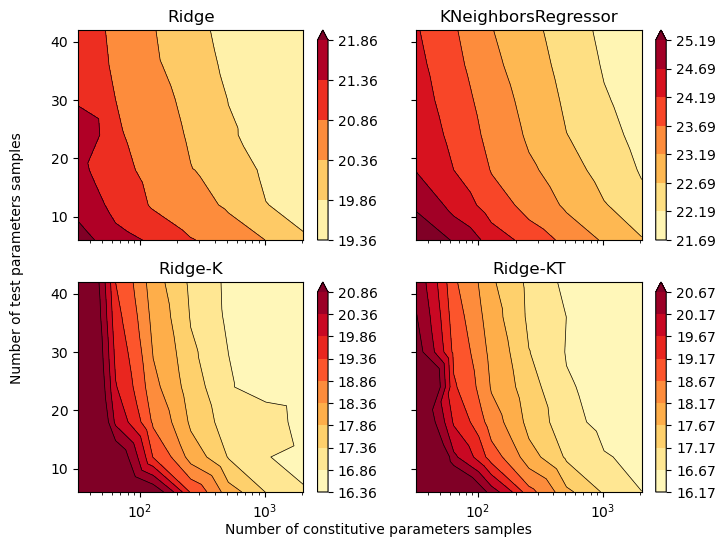

In [48]:
plot_contours_mthd_all_n(resvals_hdl,10,0.5,'YlOrRd',smalllist,"FigDrainedMAPE.pdf")

In [49]:
global_simus_u = read_grid_results(path_root,"Undrained")

In [50]:
resvals_hdl_u=[]
for vv1 in global_simus_u:
    xval,yval = vv1[:2]
    valsint = [x for x in vv1[-1] if x[0][:15]=='Holdout-Overall']
    for vi in valsint:
        resvals_hdl_u.append(vv1[:2]+[vi[1],"-".join(vi[0].split("-")[2:])[8:]])

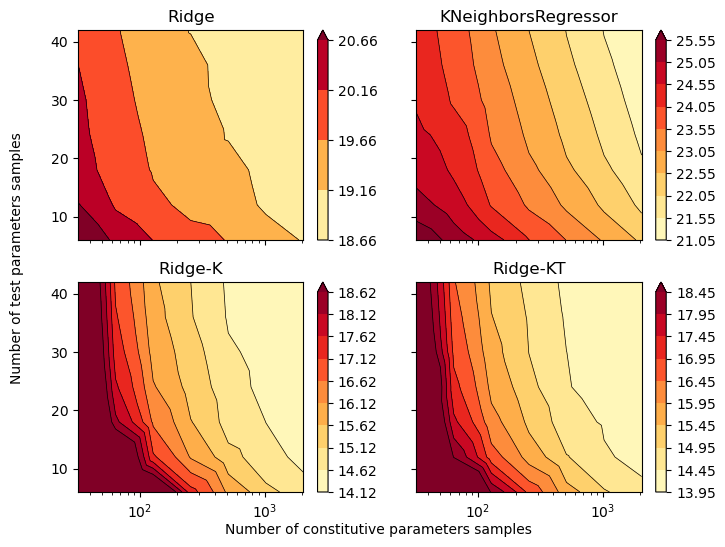

In [51]:
plot_contours_mthd_all_n(resvals_hdl_u,10,0.5,'YlOrRd',smalllist,"FigUndrainedMAPE.pdf")